 Sky View Factor (SVF): 0.544


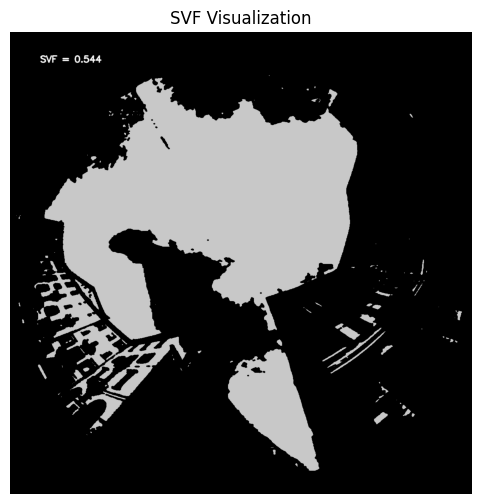

SVF visualization saved to: ./svf_visualized_image.png


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the fisheye image
image_path = "/home/asal/svf/image (13).png"  # Update path if needed
image = cv2.imread(image_path)

# Step 1: Convert the image to grayscale (or HSV for more advanced filtering)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Step 2: Basic threshold to identify sky (you can replace this with HSV filtering)
_, intensity_mask = cv2.threshold(gray, 180, 200, cv2.THRESH_BINARY)

# Step 3: Edge detection to remove strong edges
edges = cv2.Canny(gray, 50, 220)

# Step 4: Combine masks to refine sky region
combined_mask = cv2.bitwise_and(intensity_mask, cv2.bitwise_not(edges))

# Step 5: Create circular mask (valid fisheye region)
height, width = combined_mask.shape
center = (width // 2, height // 2)
radius = min(center)

y, x = np.ogrid[:height, :width]
circular_mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
combined_mask[~circular_mask] = 0

# Step 6: Clean up mask with morphological closing
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
cleaned_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

# Step 7: Weighted SVF calculation (correct for equidistant fisheye)
yy, xx = np.indices((height, width))
dx = xx - center[0]
dy = yy - center[1]
r = np.sqrt(dx**2 + dy**2)

# Convert radial distance to zenith angle (equidistant projection)
with np.errstate(divide='ignore', invalid='ignore'):
    phi = (r / radius) * (np.pi / 2)  # zenith angle in radians
    cos2_phi = np.cos(phi) ** 2
    cos2_phi[~circular_mask] = 0  # apply circular mask

# Sky mask (binary)
sky_mask = cleaned_mask > 0

# Weighted SVF
svf_weighted = np.sum(cos2_phi[sky_mask]) / np.sum(cos2_phi)
print(f" Sky View Factor (SVF): {svf_weighted:.3f}")

# Step 8: Overlay SVF on image and visualize
overlay_image = cv2.cvtColor(cleaned_mask, cv2.COLOR_GRAY2BGR)
cv2.putText(overlay_image, f"SVF = {svf_weighted:.3f}", (80, 80),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

# Save and show the result
output_path = "./svf_visualized_image.png"
cv2.imwrite(output_path, overlay_image)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.title("SVF Visualization")
plt.axis("off")
plt.show()

print(f"SVF visualization saved to: {output_path}")
